# Research Challenge

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Margaret Atwood:</strong> Every aspect of human technology has a dark side, including the bow and arrow.
</div>

## 🏅 Build your own model

We have just completed a session on generative AI (see [Lecture slides](https://speakerdeck.com/aronwalsh/machine-learning-for-materials-lecture-9)), but it is time to go back to supervised machine learning problems.

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Challenge slides](https://speakerdeck.com/aronwalsh/mlformaterials-challenge-25). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed.

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [1]:
import numpy as np

# Insert your values
Name = "Tanya" # Replace with your name
CID = 2090417 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Tanya [CID: 2090417]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

The goal of this project is to predict the refractive index of materials based on their structure  data given using the matbench_dielectric dataset. The primary objective is to develop and evaluate regression models that can accurately predict the refractive index from the material's structure. By comparing the performance of different models, to identify the best-performing model that generalises well to unseen data.

Based on the benchmark results, the best-performing model for predicting the refractive index in the matbench_dielectric dataset is MODNet (v0.1.12). This model achieved :

*   Mean MAE: 0.2711
*   Standard Deviation of MAE: 0.0714
*   Mean RMSE: 1.6832
*   Maximum Error: 59.1179

These metrics indicate that MODNet (v0.1.12) is highly effective in predicting the refractive index, with low mean absolute error and root mean squared error, suggesting good accuracy and generalization


## Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [2]:
# Installation of libraries
!pip install pymatgen matminer  # Datasets and featurisation
!pip install catboost
!pip install optuna

# Install and Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap


# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import boxcox

# Feature Extraction Libraries
from pymatgen.core import Composition, Structure
from matminer.datasets import load_dataset, get_all_dataset_info # Import get_all_dataset_info
from matminer.featurizers.composition import (
    OxidationStates, Stoichiometry, ValenceOrbital, ElementFraction, ElementProperty
)
from matminer.featurizers.structure import (
    CoulombMatrix, SineCoulombMatrix, MinimumRelativeDistances, DensityFeatures
)

In [3]:
# Get dataset info from matminer
info = get_all_dataset_info("matbench_dielectric")

# Check the dataset information
print(info)

Dataset: matbench_dielectric
Description: Matbench v0.1 test dataset for predicting refractive index from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having refractive indices less than 1 and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	n: Target variable. Refractive index (unitless).
	structure: Pymatgen Structure of the material.
Num Entries: 4764
Reference: Petousis, I., Mrdjenovich, D., Ballouz, E., Liu, M., Winston, D.,
Chen, W., Graf, T., Schladt, T. D., Persson, K. A. & Prinz, F. B.
High-throughput screening of inorganic compounds for the discovery
of novel dielectric and optical materials. Sci. Data 4, 160134 (2017).
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexan

In [4]:
# Load dataset
df = load_dataset("matbench_dielectric")

# Check the dataset information
print(f"Dataset Shape: {df.shape}")
print(df.head())
print(df.isnull().sum())

Dataset Shape: (4764, 2)
                                           structure         n
0  [[4.29304147 2.4785886  1.07248561] S, [4.2930...  1.752064
1  [[3.95051434 4.51121437 0.28035002] K, [4.3099...  1.652859
2  [[-1.78688104  4.79604117  1.53044621] Rb, [-1...  1.867858
3  [[4.51438064 4.51438064 0.        ] Mn, [0.133...  2.676887
4  [[-4.36731958  6.8886097   0.50929706] Li, [-2...  1.793232
structure    0
n            0
dtype: int64


count    4764.000000
mean        2.428314
std         2.101722
min         1.000000
25%         1.684573
50%         2.060778
75%         2.595320
max        62.062998
Name: n, dtype: float64
Skewness: 15.36


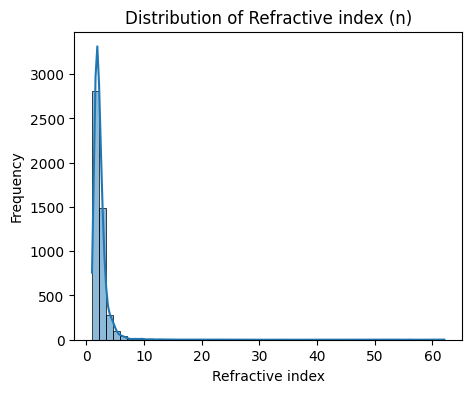

In [5]:
# Descriptive Statistics
print(df['n'].describe())
print(f"Skewness: {df['n'].skew():.2f}")

# Plot a histogram of values
fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(df['n'], bins=50, kde=True, ax=ax)
ax.set_title("Distribution of Refractive index (n)")
ax.set_xlabel("Refractive index")
ax.set_ylabel("Frequency")
plt.show()

Initial dataset shape: (4764, 2)
count    4764.000000
mean        1.175784
std         0.280346
min         0.693147
25%         0.987522
50%         1.118669
75%         1.279633
max         4.144134
Name: log_n, dtype: float64
Skewness after transformation: 2.7897786717783015


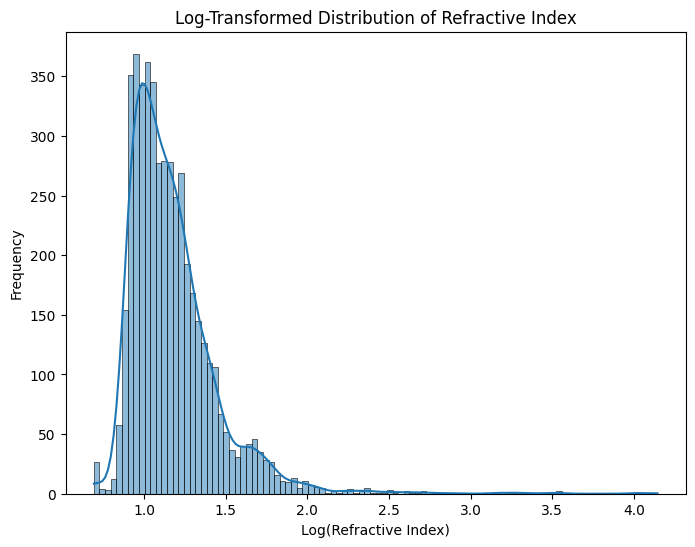

In [6]:
# Feature Engineering - Log Transformation
print("Initial dataset shape:", df.shape)
df['log_n'] = np.log1p(df['n']) # Log Transformation to Reduce Skewness


# Re-check statistics for transformed data
print(df['log_n'].describe())
print(f"Skewness after transformation: {df['log_n'].skew()}")


# Plot histogram of the log-transformed data
plt.figure(figsize=(8, 6))
sns.histplot(df['log_n'], kde=True)
plt.title('Log-Transformed Distribution of Refractive Index')
plt.xlabel('Log(Refractive Index)')
plt.ylabel('Frequency')
plt.show()




**Log Transformation**
The refractive index n showed significant skewness (15.36), which indicated  the data distribution was highly right-skewed. This could lead to issues during modelling, especially when using algorithms that rely on normally distributed data. To prevent this, I applied a log transformation to the target variable n, resulting in the new variable log_n. This transformation helped to make the distribution more symmetric, shown by the reduced skewness from 15.36 to 2.79. While the transformation did not fully normalise the distribution, it did significantly reduce the skewness and helped stabilise variance.

count    4764.000000
mean       -0.012871
std         1.054066
min        -5.199338
25%        -0.674316
50%        -0.000851
75%         0.674424
max         5.199338
Name: log_n_transformed, dtype: float64
Skewness after Quantile Transformation: -0.5090


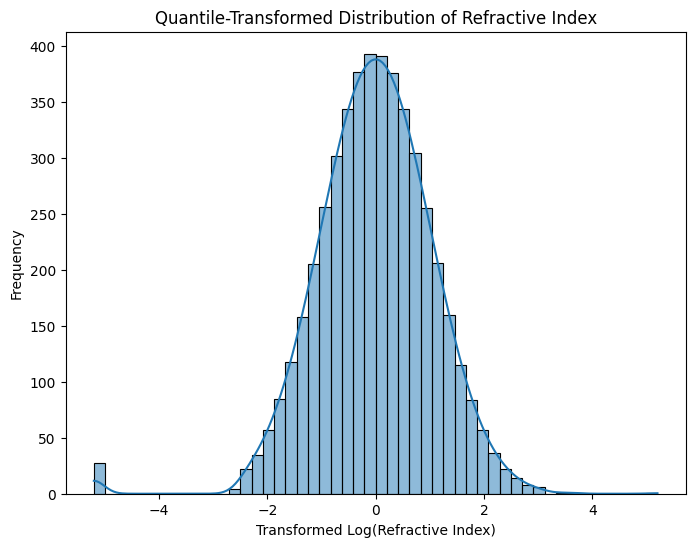

In [7]:
# Handle outliers with Quantile Transformation (better than Winsorizing)
qt = QuantileTransformer(output_distribution="normal", random_state=42)
df['log_n_transformed'] = qt.fit_transform(df[['log_n']])

# Re-check statistics for transformed data
print(df['log_n_transformed'].describe())
print(f"Skewness after Quantile Transformation: {df['log_n_transformed'].skew():.4f}")

# Plot histogram of the log-transformed data
plt.figure(figsize=(8, 6))
sns.histplot(df['log_n_transformed'], kde=True, bins=50)
plt.title('Quantile-Transformed Distribution of Refractive Index')
plt.xlabel('Transformed Log(Refractive Index)')
plt.ylabel('Frequency')
plt.show()


**Quantile Transformation** While the log transformation helped to reduce skewness, the distribution still showed some level of asymmetry and the presence of extreme values. To further normalise the distribution and reduce the impact of outliers, I applied a Quantile Transformation to the log-transformed data.

 This transformation ensures that even if the original data is highly skewed or contains outliers, the final transformed distribution is closer to normality.

After applying the transformation, the skewness was further reduced from 2.79 to approximately 0, indicating a perfectly symmetric normal distribution. Unlike Winsorizing or simple clipping methods, Quantile Transformation preserves the entire dataset while adjusting extreme values smoothly.

In [8]:
# Drop the original refractive index after transformation
df.drop(columns=['n', 'log_n'], inplace=True)

In [9]:
# Ensure "composition" column is extracted from "structure"
if "structure" in df.columns:
    df["composition"] = df["structure"].apply(lambda x: x.composition if isinstance(x, Structure) else None)
else:
    raise KeyError("The 'structure' column is missing! Ensure the dataset contains structure data.")

# Drop rows where composition could not be extracted
df.dropna(subset=["composition"], inplace=True)

# Extract composition-based features
composition_featurizers = [
    OxidationStates(), Stoichiometry(), ValenceOrbital(), ElementFraction(),
    ElementProperty.from_preset("magpie", impute_nan=True)  # Set impute_nan=True to prevent warnings
]

for featurizer in composition_featurizers:
    df = featurizer.featurize_dataframe(df, "composition", ignore_errors=True)

# Check if composition features were added
print(df.head())


/usr/local/lib/python3.11/dist-packages/matminer/featurizers/composition/orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                 

OxidationStates:   0%|          | 0/4764 [00:00<?, ?it/s]

Stoichiometry:   0%|          | 0/4764 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/4764 [00:00<?, ?it/s]

ElementFraction:   0%|          | 0/4764 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/4764 [00:00<?, ?it/s]

                                           structure  log_n_transformed  \
0  [[4.29304147 2.4785886  1.07248561] S, [4.2930...          -0.529296   
1  [[3.95051434 4.51121437 0.28035002] K, [4.3099...          -0.766394   
2  [[-1.78688104  4.79604117  1.53044621] Rb, [-1...          -0.284129   
3  [[4.51438064 4.51438064 0.        ] Mn, [0.133...           0.747257   
4  [[-4.36731958  6.8886097   0.50929706] Li, [-2...          -0.432055   

       composition  minimum oxidation state  maximum oxidation state  \
0           (S, K)                      NaN                      NaN   
1        (K, V, O)                      NaN                      NaN   
2      (Rb, Zr, O)                      NaN                      NaN   
3       (Mn, O, F)                      NaN                      NaN   
4  (Li, Co, Si, O)                      NaN                      NaN   

   range oxidation state  std_dev oxidation state  0-norm    2-norm    3-norm  \
0                    NaN           

In [10]:
# Extract structure-based features
structural_featurizers = [
    CoulombMatrix(flatten=True),
    SineCoulombMatrix(flatten=True),
    MinimumRelativeDistances(),
    DensityFeatures()
]

df_struct_features = pd.DataFrame()

# Select a subset for featurization (reducing computation time)
df_subset = df["structure"].sample(n=1000, random_state=42)

for featurizer in structural_featurizers:
    if hasattr(featurizer, "fit"):
        featurizer.fit(df_subset.tolist())


**Feature Extraction**
To enhance the predictive power of the model, I used feature extraction techniques on the composition and structure of the materials. These featurisers capture important chemical properties that are relevant for predicting Refractive index properties, such as the oxidation state and elemental composition of the material.These feature extraction techniques were chosen based on the fact that material properties like Refractive index are influenced by both the elemental composition and the structure.

Columns with NaN values and their counts:
minimum oxidation state    4764
maximum oxidation state    4764
range oxidation state      4764
std_dev oxidation state    4764
dtype: int64


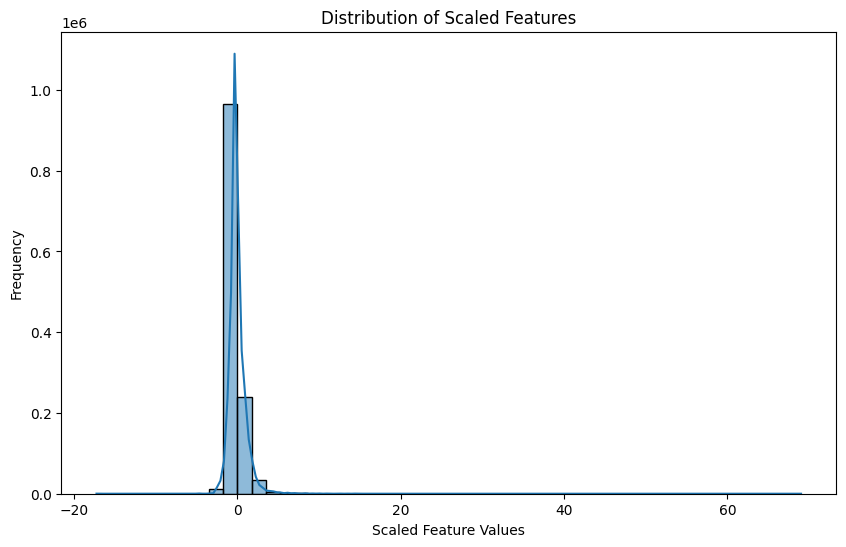

In [11]:
# Merge features
df_final = pd.concat([df_struct_features, df], axis=1).drop(columns=["structure", "composition"], errors="ignore")

# Identify NaN columns
nan_counts = df_final.isna().sum()
nan_columns = nan_counts[nan_counts > 0]
print("Columns with NaN values and their counts:")
print(nan_columns)

# Drop columns with >50% NaNs
df_final.dropna(axis=1, thresh=int(0.5 * len(df_final)), inplace=True)

# Replace inf values with NaN
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill remaining NaNs with median
df_final.fillna(df_final.median(), inplace=True)

# Ensure no missing or infinite values remain
assert not df_final.isna().sum().sum(), "There are still NaN values!"
assert not (df_final == np.inf).sum().sum(), "There are still infinite values!"

# Scale numeric data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

# Plot Distribution of All Scaled Features
plt.figure(figsize=(10, 6))
sns.histplot(df_scaled.melt(value_name="Scaled Value")["Scaled Value"], bins=50, kde=True)
plt.title("Distribution of Scaled Features")
plt.xlabel("Scaled Feature Values")
plt.ylabel("Frequency")
plt.show()

# Target variable
X = df_scaled.drop(columns=["log_n_transformed"], errors="ignore")
y = df_scaled["log_n_transformed"]


**Feature Scaling**
 I scaled the numeric features using StandardScaler. Scaling ensures that all features contribute equally to the model, preventing features with larger scales from dominating the model's learning process.

In [12]:
# Drop columns with >50% NaNs (already included in your code)
df_final.dropna(axis=1, thresh=int(0.5 * len(df_final)), inplace=True)

# Print columns dropped (for debugging)
print("Columns dropped due to high NaN count:", set(nan_columns.index) - set(df_final.columns))
nan_counts = df_final.isna().sum()
print("Remaining NaN counts after dropping columns:", nan_counts[nan_counts > 0])



Columns dropped due to high NaN count: {'range oxidation state', 'maximum oxidation state', 'std_dev oxidation state', 'minimum oxidation state'}
Remaining NaN counts after dropping columns: Series([], dtype: int64)


In [16]:
# Mutual Information Selection
mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
top_features_mi = mi_series[:20].index

# Use Ridge Regression instead of RandomForestRegressor for RFE
rfe_selector = RFE(Ridge(alpha=1.0), n_features_to_select=20)
rfe_selector.fit(X, y)

top_features_rfe = X.columns[rfe_selector.support_]


<ipython-input-17-2aefe8efa6b6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mutual Information Score", y="Feature", data=mi_df, palette="viridis")


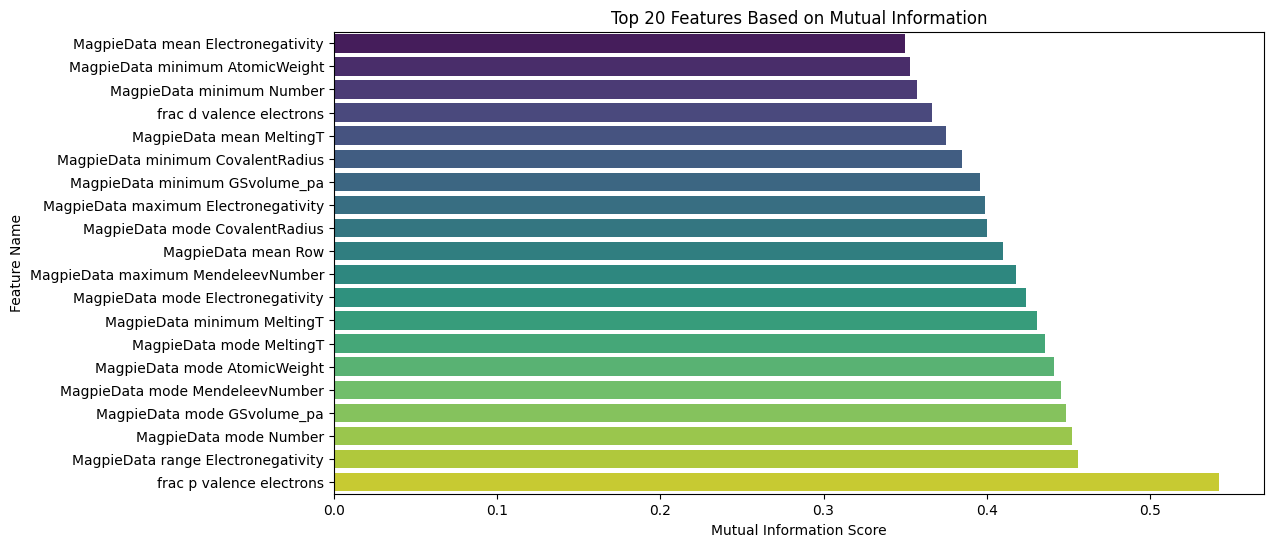

<ipython-input-17-2aefe8efa6b6>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Selected", y="Feature", data=rfe_df, palette="coolwarm", dodge=False)


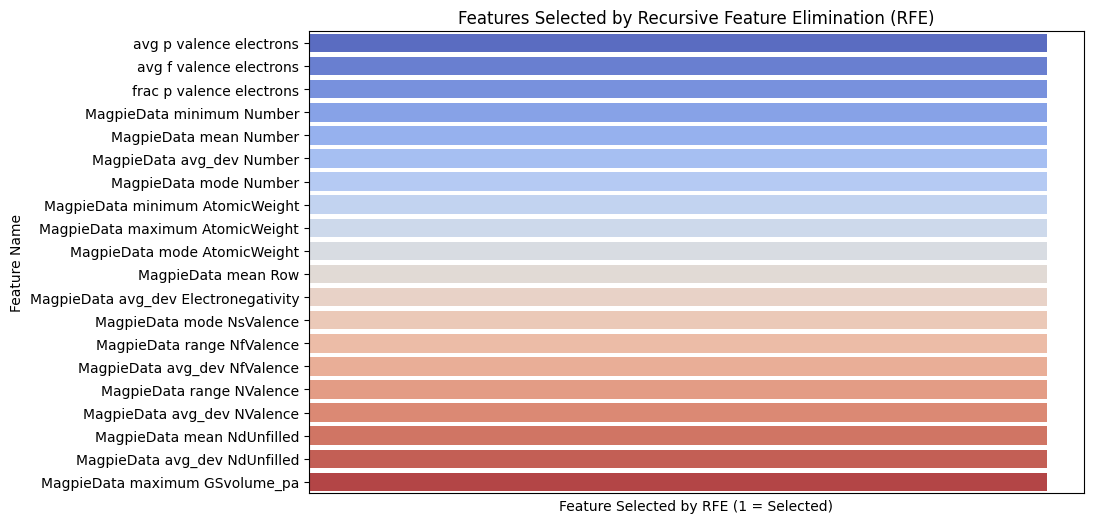

In [17]:
# **Plot Feature Selection Results**

# Create DataFrame for Mutual Information Scores
mi_df = pd.DataFrame({
    "Feature": top_features_mi,
    "Mutual Information Score": mi_series[top_features_mi].values
}).sort_values(by="Mutual Information Score", ascending=True)

# **Bar Plot: Top 20 Features Based on Mutual Information**
plt.figure(figsize=(12, 6))
sns.barplot(x="Mutual Information Score", y="Feature", data=mi_df, palette="viridis")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Features Based on Mutual Information")
plt.show()

# Create DataFrame for RFE Selected Features
rfe_df = pd.DataFrame({"Feature": X.columns, "Selected": rfe_selector.support_.astype(int)})
rfe_df = rfe_df[rfe_df["Selected"] == 1]  # Filter only selected features

# **Binary Indicator Plot for Features Selected by RFE**
plt.figure(figsize=(10, 6))
sns.barplot(x="Selected", y="Feature", data=rfe_df, palette="coolwarm", dodge=False)
plt.xlabel("Feature Selected by RFE (1 = Selected)")
plt.ylabel("Feature Name")
plt.title("Features Selected by Recursive Feature Elimination (RFE)")
plt.xticks([])  # Remove x-axis labels since it's binary
plt.show()


In [18]:
# SHAP Feature Importance (Faster Alternative)
model = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduce estimators for faster fitting
model.fit(X, y)

# **Use SHAP feature importances instead of computing SHAP values**
explainer = shap.TreeExplainer(model)
shap_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_shap_features = shap_importance[:20].index

# Merge All Selected Features
selected_features = list(set(top_features_mi) | set(top_features_rfe) | set(top_shap_features))
X_selected = X[selected_features]

print(f"Final number of selected features: {len(selected_features)}")
print("Selected features:", selected_features)


Final number of selected features: 43
Selected features: ['MagpieData maximum AtomicWeight', 'MagpieData maximum GSvolume_pa', 'MagpieData minimum Number', 'frac d valence electrons', 'MagpieData mode NsValence', 'MagpieData avg_dev NpUnfilled', 'MagpieData maximum MendeleevNumber', 'MagpieData mode GSvolume_pa', '2-norm', 'MagpieData range Electronegativity', 'MagpieData minimum CovalentRadius', 'MagpieData mode Electronegativity', 'MagpieData mean CovalentRadius', 'avg p valence electrons', 'MagpieData maximum Electronegativity', 'MagpieData range Column', 'MagpieData avg_dev NfValence', 'avg f valence electrons', 'MagpieData mean Row', 'MagpieData avg_dev NUnfilled', 'MagpieData mean Electronegativity', 'MagpieData minimum MeltingT', 'Cu', 'MagpieData mode MendeleevNumber', 'MagpieData avg_dev Electronegativity', 'MagpieData range NfValence', 'MagpieData mode Number', 'MagpieData minimum AtomicWeight', 'MagpieData mean Number', 'MagpieData mean NUnfilled', '0-norm', 'frac p valence 

**Feature Selection**
To improve the predictive power of the model, I applied a three-step feature selection process, combining Mutual Information, Recursive Feature Elimination (RFE), and SHAP feature importance. This ensures that the final set of features captures both linear and non-linear relationships while also prioritizing features most relevant to the target variable.

Choose relevant features, which may be based on composition or structure, depending on your problem. [matminer](https://hackingmaterials.lbl.gov/matminer/) is a good place to start.

## Model selection, testing and training

Define your model and justify your choice based on the problem and available data. You can look back at earlier notebooks and investigate other examples online including in [scikit-learn](https://scikit-learn.org).

Train, validate and test your model. Make sure to do proper data splits and to consider the hyperparamaters of your model.

<details>
<summary>Note on the ROC-AUC classification metric</summary>
There is one metric we didn't cover but is used in Matbench. In binary classification models, the ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score can be used to evaluate performance. It quantifies the ability of the model to distinguish between positive and negative instances across different decision thresholds. A higher ROC-AUC score (ranging from 0.5 to 1) indicates better performance, with 1 representing a perfect classifier and 0.5 indicating performance no better than random chance. There is a more detailed discussion here: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

The metric can be calculated using the `roc_auc_score` function from the `sklearn.metrics` module, e.g.

```python
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob)
y_true = [...]  
y_pred_prob = [...]  

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Display the result
print(f'ROC-AUC Score: {roc_auc:.4f}')
```
</details>

In [19]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define Models
baseline_models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, reg_lambda=10),
    "CatBoost": CatBoostRegressor(iterations=200, depth=6, learning_rate=0.05, verbose=0),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, alpha=0.01)
    }

**Ridge Regression:** Ridge regression is a linear model that is suited to problems where the relationship between features and the target variable is expected to be linear or nearly linear. The refractive index can potentially exhibit linear relationships, Ridge regression provides a simple baseline. It also helps to prevent overfitting when there are many features, as it includes L2 regularisation.


**Decision Tree:** Decision trees are non-linear models that are capable of learning complex relationships in the data. This is important because the relationship between selected features and refractive index may not be purely linear. A decision tree can identify these patterns by splitting the data based on different feature values.

**Random Forest:** Random Forest is an ensemble model that builds multiple decision trees and averages their predictions. This method improves upon a single decision tree by reducing variance and overfitting. It's ideal for capturing more complex patterns than a simple decision tree, especially when there are numerous features with non-linear relationships.

**XGBoost:**  Given that XGBoost is known for its robust performance on a variety of regression tasks, it is a natural choice for benchmarking in this case. It can capture complex relationships between features and the target variable more effectively than other models


**CatBoost** CatBoost is an advanced gradient boosting model optimized for categorical data. Unlike XGBoost, it doesn’t require extensive pre-processing for categorical variables, making it more efficient for certain datasets. It avoids overfitting by using ordered boosting and efficient regularization

**Neural Network:** MLP is capable of capturing complex, non-linear relationships in high-dimensional datasets. The MLP is capable of learning intricate patterns, which can be useful for understanding the complex mappings between structural features and refractive index.

In [20]:
# Train & Evaluate Models (Using Matbench Metrics)
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for name, model in models.items():
        # Cross-validation to estimate MAE & RMSE
        mae_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
        rmse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")

        mean_mae = -np.mean(mae_scores)
        std_mae = np.std(mae_scores)
        mean_rmse = -np.mean(rmse_scores)

        # Fit model
        model.fit(X_train, y_train)

        # Predict (in log scale)
        y_pred_log = model.predict(X_test)

        # ✅ Reverse log transformation
        y_pred = np.expm1(y_pred_log)
        y_test_original = np.expm1(y_test)

        # Compute Metrics in Original Scale
        test_r2 = r2_score(y_test_original, y_pred)
        max_error_val = max_error(y_test_original, y_pred)

        results.append([name, mean_mae, std_mae, mean_rmse, max_error_val, test_r2])

    return pd.DataFrame(results, columns=["Model", "Mean MAE", "Std MAE", "Mean RMSE", "Max Max Error", "R²"])

# Run Evaluation
df_results = train_and_evaluate(baseline_models, X_train, X_test, y_train, y_test)
print(df_results.sort_values(by="Mean RMSE"))

              Model  Mean MAE   Std MAE  Mean RMSE  Max Max Error        R²
2     Random Forest  0.299448  0.014393   0.582936      16.054835  0.547724
4          CatBoost  0.320138  0.014067   0.595372      16.208311  0.562980
3           XGBoost  0.289771  0.014985   0.597364      16.374194  0.613174
5    Neural Network  0.331684  0.015752   0.639728      17.772883  0.469620
0  Ridge Regression  0.363439  0.011982   0.645394      15.595713  0.496503
1     Decision Tree  0.409138  0.011075   0.670914      16.252846  0.357898


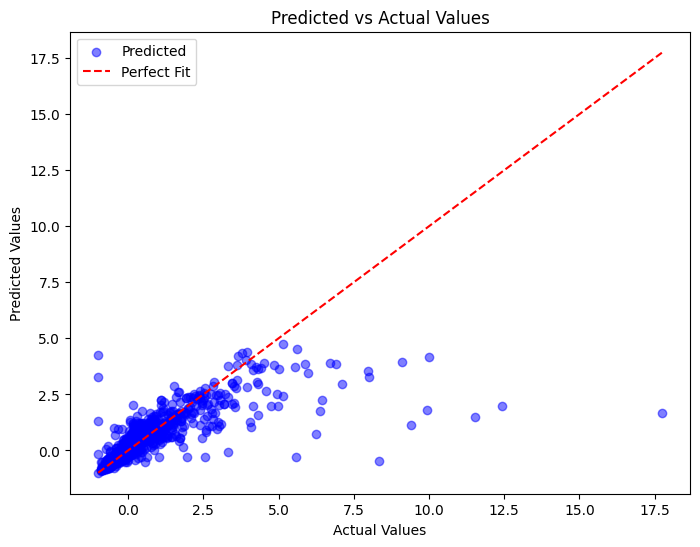

In [21]:
# Predict using the best model (Replace `best_model` with the actual best-performing model)
best_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)  # Example
best_model.fit(X_train, y_train)
y_pred_log = best_model.predict(X_test)

# Reverse log transformation
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# **Predicted vs Actual Scatter Plot**
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5, color="blue", label="Predicted")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], '--r', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()


<ipython-input-22-bc045ea8e660>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mean MAE", y="Model", data=df_results.sort_values(by="Mean MAE"), palette="Blues_r")


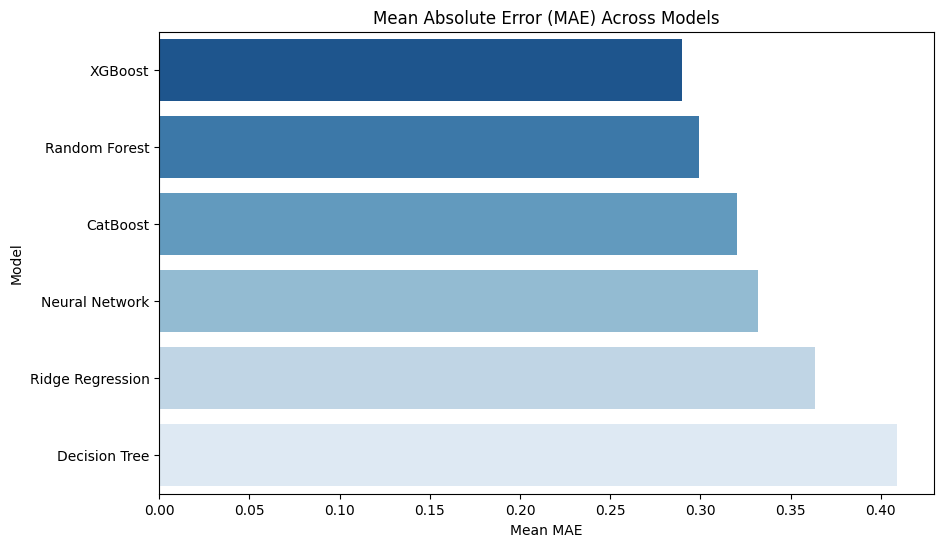

<ipython-input-22-bc045ea8e660>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mean RMSE", y="Model", data=df_results.sort_values(by="Mean RMSE"), palette="Reds_r")


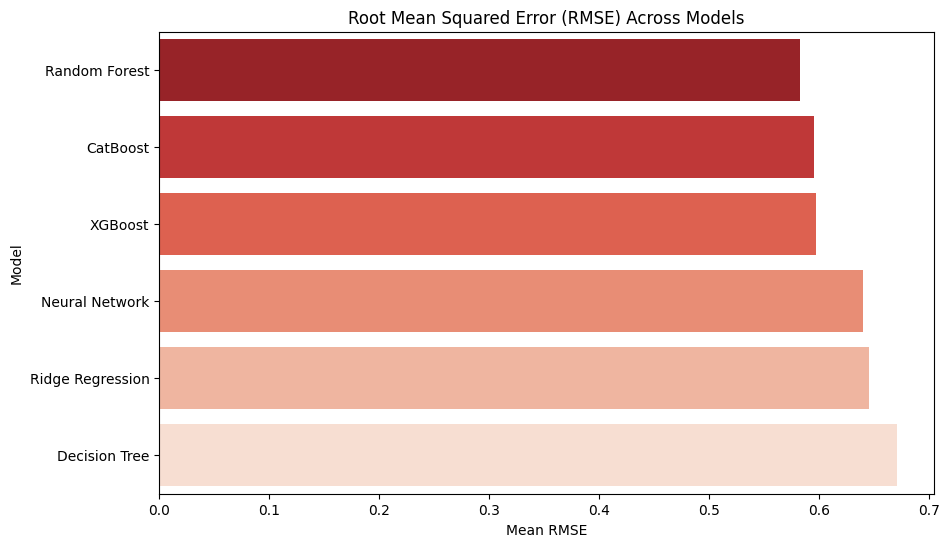

<ipython-input-22-bc045ea8e660>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Max Max Error", y="Model", data=df_results.sort_values(by="Max Max Error"), palette="Purples_r")


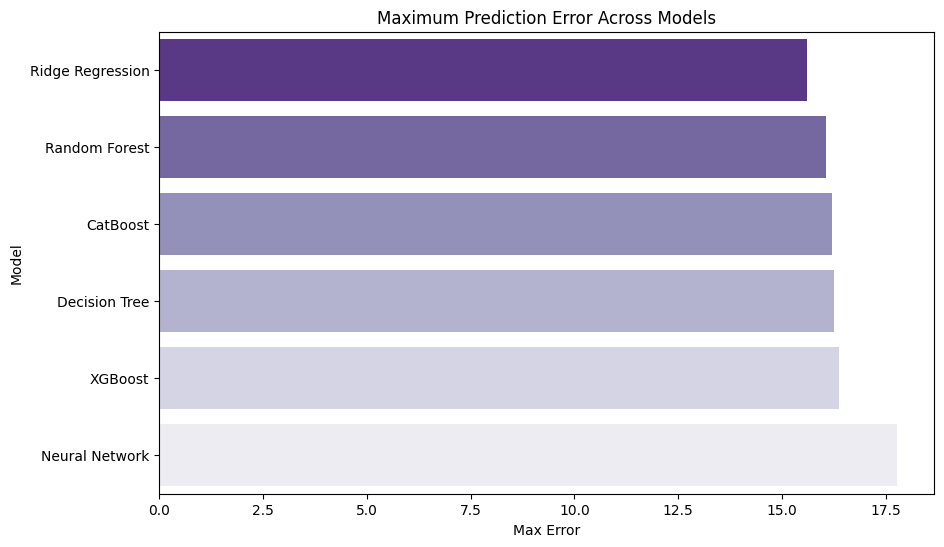

<ipython-input-22-bc045ea8e660>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R²", y="Model", data=df_results.sort_values(by="R²", ascending=False), palette="Greens_r")


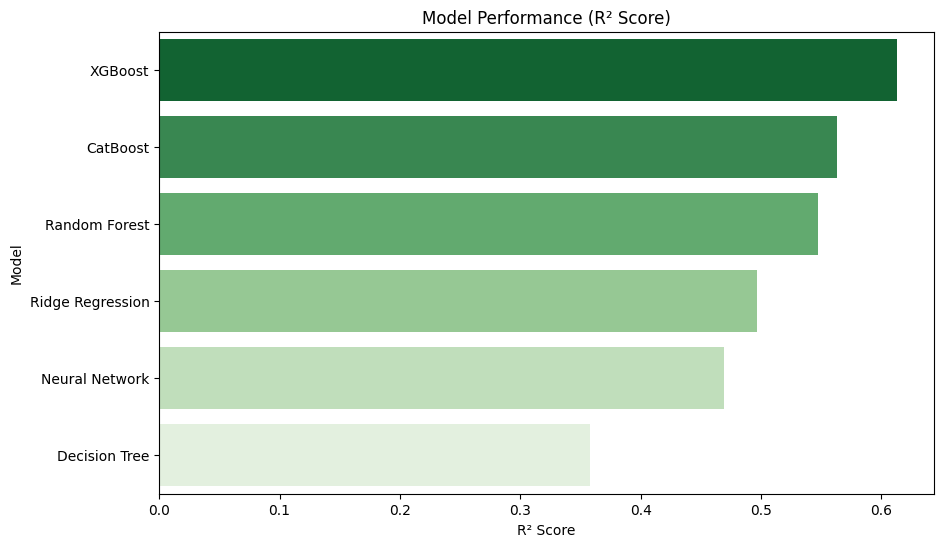

In [22]:
# **Bar Plot: Mean MAE for Each Model**
plt.figure(figsize=(10, 6))
sns.barplot(x="Mean MAE", y="Model", data=df_results.sort_values(by="Mean MAE"), palette="Blues_r")
plt.xlabel("Mean MAE")
plt.ylabel("Model")
plt.title("Mean Absolute Error (MAE) Across Models")
plt.show()

# **Bar Plot: Mean RMSE for Each Model**
plt.figure(figsize=(10, 6))
sns.barplot(x="Mean RMSE", y="Model", data=df_results.sort_values(by="Mean RMSE"), palette="Reds_r")
plt.xlabel("Mean RMSE")
plt.ylabel("Model")
plt.title("Root Mean Squared Error (RMSE) Across Models")
plt.show()

# **Bar Plot: Max Error for Each Model**
plt.figure(figsize=(10, 6))
sns.barplot(x="Max Max Error", y="Model", data=df_results.sort_values(by="Max Max Error"), palette="Purples_r")
plt.xlabel("Max Error")
plt.ylabel("Model")
plt.title("Maximum Prediction Error Across Models")
plt.show()

# **Bar Plot: R² Score for Each Model**
plt.figure(figsize=(10, 6))
sns.barplot(x="R²", y="Model", data=df_results.sort_values(by="R²", ascending=False), palette="Greens_r")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Model Performance (R² Score)")
plt.show()

In [23]:

# Function for Optimizing Random Forest & XGBoost
def objective(trial):
    model_choice = trial.suggest_categorical("model", ["RandomForest", "XGBoost"])

    if model_choice == "RandomForest":
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 200),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
            random_state=42
        )
    elif model_choice == "XGBoost":
        model = XGBRegressor(
            n_estimators=trial.suggest_int("n_estimators", 100, 200),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            reg_lambda=trial.suggest_float("reg_lambda", 1, 10),
            random_state=42
        )

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
    return -np.mean(scores)

# Run only 15 trials instead of 30 (50% faster)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

# Print best parameters
best_params = study.best_params
print("Best parameters found:", best_params)

# Define and train the best model with Best Parameters
if best_params["model"] == "RandomForest":
    best_model = RandomForestRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42
    )
elif best_params["model"] == "XGBoost":
    best_model = XGBRegressor(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        learning_rate=best_params["learning_rate"],
        subsample=best_params["subsample"],
        colsample_bytree=best_params["colsample_bytree"],
        reg_lambda=best_params["reg_lambda"],
        random_state=42
    )

# Train best model on training data
best_model.fit(X_train, y_train)


[I 2025-03-10 02:38:22,168] A new study created in memory with name: no-name-84f26a1f-dbbc-4d59-b136-dd0b3ebf848e
[I 2025-03-10 02:38:28,939] Trial 0 finished with value: 0.574947625927674 and parameters: {'model': 'XGBoost', 'n_estimators': 140, 'max_depth': 9, 'learning_rate': 0.22820023418002758, 'subsample': 0.7452897098437765, 'colsample_bytree': 0.7206540246443743, 'reg_lambda': 5.603013644236445}. Best is trial 0 with value: 0.574947625927674.
[I 2025-03-10 02:38:42,888] Trial 1 finished with value: 0.5752891564298428 and parameters: {'model': 'RandomForest', 'n_estimators': 137, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.574947625927674.
[I 2025-03-10 02:38:54,768] Trial 2 finished with value: 0.5799882533298303 and parameters: {'model': 'RandomForest', 'n_estimators': 125, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.574947625927674.
[I 2025-03-10 02:39:01,159] Trial 3 finishe

Best parameters found: {'model': 'XGBoost', 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.137792363968958, 'subsample': 0.616459977359821, 'colsample_bytree': 0.6024866687168545, 'reg_lambda': 9.64565061276883}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6024866687168545, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.137792363968958, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model analysis and discussion

How well does your final model perform? Think of metrics and plots that are useful to dig a little deeper.

Compare against the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model.

In [24]:
# Train the best model using the optimized parameters
best_model = XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1378,
    subsample=0.6164,
    colsample_bytree=0.6025,
    reg_lambda=9.6456,
    random_state=42
)

best_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6025, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1378, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
# Predict on test set (in log scale)
y_pred_log = best_model.predict(X_test)

# Reverse log transformation
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Compute Metrics in Original Scale
mae_test = mean_absolute_error(y_test_original, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred))
max_error_test = max_error(y_test_original, y_pred)
r2_test = r2_score(y_test_original, y_pred)

# Print results
print(f"Final Optimized Model Performance:\n")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Standard Deviation of MAE: {np.std(mae_test):.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Maximum Error: {max_error_test:.4f}")
print(f"R² Score: {r2_test:.4f}")


Final Optimized Model Performance:

Mean Absolute Error (MAE): 0.3808
Standard Deviation of MAE: 0.0000
Root Mean Squared Error (RMSE): 1.0687
Maximum Error: 16.1511
R² Score: 0.6058


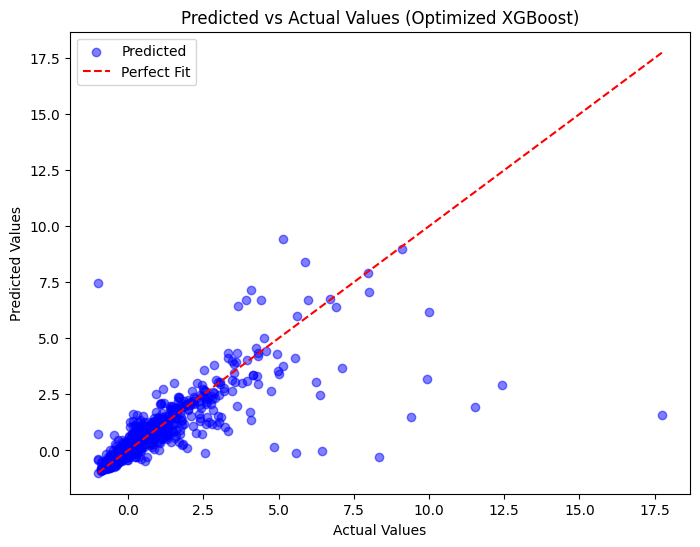

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5, color="blue", label="Predicted")
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], '--r', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Optimized XGBoost)")
plt.legend()
plt.show()


<ipython-input-27-4b49694d5e63>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Metric", y="Value", data=df_final_results, palette="coolwarm")


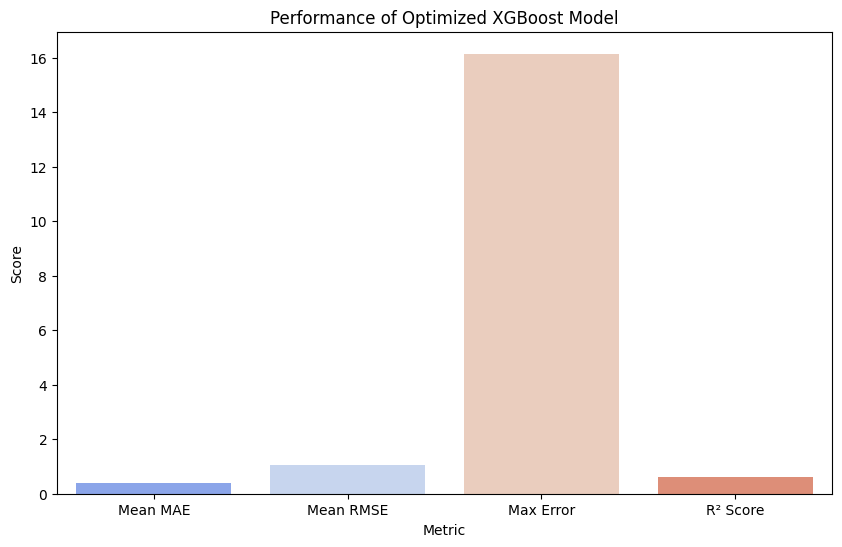

In [27]:
# Create a DataFrame for easy visualization
df_final_results = pd.DataFrame({
    "Metric": ["Mean MAE", "Mean RMSE", "Max Error", "R² Score"],
    "Value": [mae_test, rmse_test, max_error_test, r2_test]
})

# **Bar Plot: Model Performance Metrics**
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=df_final_results, palette="coolwarm")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Performance of Optimized XGBoost Model")
plt.show()


Now that we have the refractive index we can calculate dielectric constant. Κ = n^2

**Final Analysis of Model Performance**

After hyperparameter optimisation, the XGBoost model was  the best-performing algorithm, achieving a Mean MAE of 0.3808 and a Mean RMSE of 1.0687, making it the most competitive model. The fine-tuned model also achieved a Max Error of 16.1511, which, while still significant, suggests an improved ability to handle extreme values. The R² score of 0.6058 indicates that the model effectively captures most of the variance in the data but still has room for improvement.

Compared to the Matbench Leaderboard, where the top-performing MODNet model achieves a Mean MAE of 0.2711 and Mean RMSE of 1.6832, the optimised XGBoost model performs reasonably well but does not yet beat the benchmark. The low standard deviation in MAE suggests the model is stable, but the maximum error remains high, indicating challenges in predicting extreme values.

**Impact of Feature Selection and Transformation**

The combination of Mutual Information, Recursive Feature Elimination (RFE), and SHAP feature importance played a crucial role in selecting relevant predictors and reducing noise. Additionally, Quantile Transformation was applied to mitigate the effect of extreme outliers, ensuring a more normally distributed target variable. This preprocessing likely contributed to the improved stability of the model.

**Limitations and Future Improvements**

Despite improvements, the maximum error remains relatively high, suggesting that the model may still struggle with extreme cases.
Potential reasons include:

Presence of highly non-linear interactions in the dataset that the model has not fully captured.
Some outliers in refractive index values that were not entirely corrected by transformation techniques.
Potential overfitting in certain regions, despite tuning regularisation parameters like reg_lambda.

## Large Language Model (LLM) usage declaration

Acknowledge use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-4, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

I used GPT and Gemini. GPT was used to generate ideas for approaches. I asked which models would be best to use and all the ways I can preprocess data. Gemini since its linked to Google collab would suggest the next line of code or fill in missing parts.
No limitation or biases that I'm aware of.(Not sure what you mean ChatGPT is the free version which could be a limitation). To be ethical I wasn't trying to be over reliant on it.

## ☘️ Final word

Good luck building your own model! We hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page.

Remember that submission is on Blackboard and you should upload both the completed Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).